In [57]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import grid_search
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.decomposition import RandomizedPCA
from sklearn import linear_model

# Data Ingestion

#### raw files

s3://dataincubator-course/mldata/music_train.tar.gz

In [8]:
!wget https://s3.amazonaws.com/thedataincubator-course/mldata/music_train.tar.gz

--2016-04-21 15:32:03--  https://s3.amazonaws.com/thedataincubator-course/mldata/music_train.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.50.4
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.50.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185785908 (177M) [application/x-tar]
Saving to: ‘music_train.tar.gz’

100%[======================================>] 185,785,908 30.7MB/s   in 5.8s   

2016-04-21 15:32:10 (30.4 MB/s) - ‘music_train.tar.gz’ saved [185785908/185785908]



#### train set

s3://dataincubator-course/mldata/music_train_labels.csv

In [2]:
!wget https://s3.amazonaws.com/thedataincubator-course/mldata/music_train_labels.csv

--2016-04-21 15:13:23--  https://s3.amazonaws.com/thedataincubator-course/mldata/music_train_labels.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.49.75
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.49.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31018 (30K) [text/csv]
Saving to: ‘music_train_labels.csv’

100%[======================================>] 31,018      --.-K/s   in 0.02s   

2016-04-21 15:13:23 (1.68 MB/s) - ‘music_train_labels.csv’ saved [31018/31018]



#### test set

s3://dataincubator-course/mldata/music_feature_extraction_test.tar.gz

In [3]:
!wget https://s3.amazonaws.com/thedataincubator-course/mldata/music_feature_extraction_test.tar.gz

--2016-04-21 15:15:56--  https://s3.amazonaws.com/thedataincubator-course/mldata/music_feature_extraction_test.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.15.48
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.15.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23122196 (22M) [application/x-tar]
Saving to: ‘music_feature_extraction_test.tar.gz’

100%[======================================>] 23,122,196  28.8MB/s   in 0.8s   

2016-04-21 15:15:57 (28.8 MB/s) - ‘music_feature_extraction_test.tar.gz’ saved [23122196/23122196]



##### additional set

s3://dataincubator-course/mldata/df_train_anon.csv

In [4]:
!wget https://s3.amazonaws.com/thedataincubator-course/mldata/df_train_anon.csv

--2016-04-21 15:17:36--  https://s3.amazonaws.com/thedataincubator-course/mldata/df_train_anon.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.11.24
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.11.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13982389 (13M) [text/csv]
Saving to: ‘df_train_anon.csv’

100%[======================================>] 13,982,389  53.5MB/s   in 0.2s   

2016-04-21 15:17:37 (53.5 MB/s) - ‘df_train_anon.csv’ saved [13982389/13982389]



In [10]:
!ls

data		   music_feature_extraction_test.tar.gz  music_train.tar
data.py		   Music.ipynb				 music_train.tar.gz
df_train_anon.csv  music_train_labels.csv		 README.md


In [9]:
!tar -xvzf music_train.tar.gz

data/train/train_0001.mp3
data/train/train_0002.mp3
data/train/train_0003.mp3
data/train/train_0004.mp3
data/train/train_0005.mp3
data/train/train_0006.mp3
data/train/train_0007.mp3
data/train/train_0008.mp3
data/train/train_0009.mp3
data/train/train_0010.mp3
data/train/train_0011.mp3
data/train/train_0012.mp3
data/train/train_0013.mp3
data/train/train_0014.mp3
data/train/train_0015.mp3
data/train/train_0016.mp3
data/train/train_0017.mp3
data/train/train_0018.mp3
data/train/train_0019.mp3
data/train/train_0020.mp3
data/train/train_0021.mp3
data/train/train_0022.mp3
data/train/train_0023.mp3
data/train/train_0024.mp3
data/train/train_0025.mp3
data/train/train_0026.mp3
data/train/train_0027.mp3
data/train/train_0028.mp3
data/train/train_0029.mp3
data/train/train_0030.mp3
data/train/train_0031.mp3
data/train/train_0032.mp3
data/train/train_0033.mp3
data/train/train_0034.mp3
data/train/train_0035.mp3
data/train/train_0036.mp3
data/train/train_0037.mp3
data/train/train_0038.mp3
data/train/t

In [83]:
train_files = ["./data/train/train_%04d.mp3" % i for i in xrange(1, 1168)] ###1168

In [133]:
test_files = ["./data/feature_extraction_test/fe_test_%04d.mp3" % i for i in xrange(1, 146)]### 145

In [51]:
train_files[0]

'./data/train/train_0001.mp3'

In [81]:
class SoundTransform():
    def __init__(self):
         pass
    
    def transform(self, X):
        monos = [librosa.load(x, sr = 44100) for x in X]
        zeros = [librosa.feature.zero_crossing_rate(mono[0]) for mono in monos]
        zero_means = pd.Series([np.mean(zero) for zero in zeros], name = 'zero_means')
        zero_stds =  pd.Series([np.std(zero) for zero in zeros] , name = 'zero_stds')
        rmses = [librosa.feature.rmse(mono[0]) for mono in monos]
        rmse_means = pd.Series([np.mean(rmse) for rmse in rmses], name = 'rmse_means')
        rmse_stds = pd.Series([np.std(rmse) for rmse in rmses], name = 'rmse_stds')
        features = [zero_means,zero_stds, rmse_means, rmse_stds]
        df = pd.concat(features, axis=1, keys=[feature.name for feature in features])
        return df
        

In [84]:
trans = SoundTransform()

In [85]:
trans.transform(train_files)

,zero_means,zero_stds,rmse_means,rmse_stds
0,0.065075,0.028204,2.864222,1.216570
1,0.064189,0.037439,3.243064,1.705684
2,0.030504,0.013343,0.781422,0.762356
3,0.047627,0.063503,2.262406,1.350478
4,0.080152,0.022575,7.587574,1.753174
5,0.039480,0.027076,4.041835,1.488826
6,0.050218,0.051841,2.885364,1.485458
7,0.079094,0.025243,7.223564,1.385457
8,0.074059,0.060100,7.030616,4.191195
9,0.034840,0.020688,5.000144,1.375827


In [87]:
train_data = trans.transform(train_files)

In [128]:
test_data = trans.transform(test_files)

In [90]:
train_labels = pd.read_csv('music_train_labels.csv')

In [106]:
y = train_labels['genre'].values

In [96]:
X = train_data[['zero_means','zero_stds','rmse_means','rmse_stds']].values

In [99]:
X.shape

(1167, 4)

In [100]:
y.shape

(1167,)

In [215]:
def labelEncodeTransformer():
    def __init__(self):
        self.le = preprocessing.LabelEncoder()
        pass
    def fit(y):
        y = self.le.fit(y)
        return y
    def transform(y):
        y = self.le.transform(y)
        return y
    def inverse(y):
        y = self.le.inverse_transform(y)
        return y

In [107]:
le = preprocessing.LabelEncoder()

In [108]:
le.fit(y)

LabelEncoder()

In [109]:
le.classes_

array(['electronic', 'folkcountry', 'jazz', 'raphiphop', 'rock'], dtype=object)

In [110]:
y = le.transform(y) 

In [129]:
X_test = test_data[['zero_means','zero_stds','rmse_means','rmse_stds']].values

{'max_depth': 3}


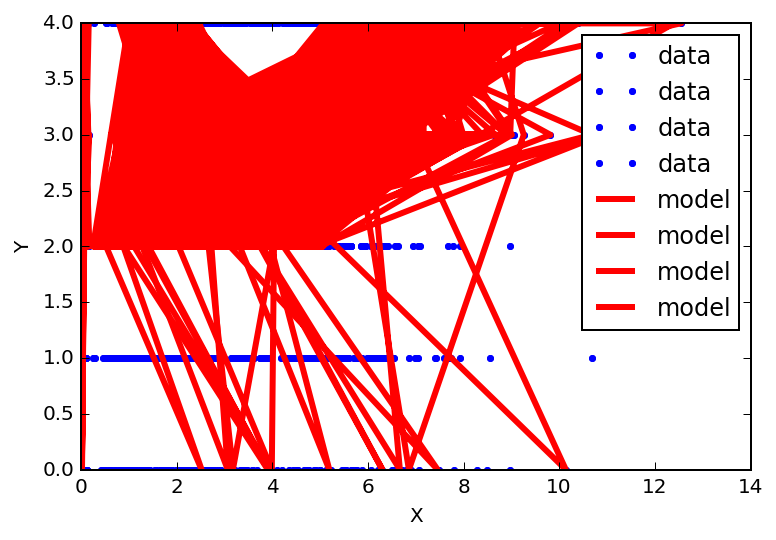

In [116]:
est = tree.DecisionTreeClassifier()
gs = grid_search.GridSearchCV(
    est,
    {"max_depth": range(1,11)}, ## {"cv": range(2,11)},
    cv = 10,  # 5-fold cross validation
    n_jobs=2,  # run each hyperparameter in one of two parallel jobs
    scoring='mean_squared_error'
)
gs.fit(X, y)
print gs.best_params_

plt.plot(X, y, 'b.', label='data')
line = plt.plot(X, gs.predict(X), 'r-', label='model')
plt.setp(line, linewidth=3.)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='upper right')
plt.show()

In [130]:
ypreds= le.inverse_transform(gs.predict(X_test))

In [135]:
 filenames_test_files = ["fe_test_%04d.mp3" % i for i in xrange(1, 146)]

In [136]:
ypreds_dict = {}
for f,g in zip(filenames_test_files,ypreds):
    ypreds_dict[f]=g
    

In [137]:
ypreds_dict

{'fe_test_0001.mp3': 'jazz',
 'fe_test_0002.mp3': 'rock',
 'fe_test_0003.mp3': 'jazz',
 'fe_test_0004.mp3': 'jazz',
 'fe_test_0005.mp3': 'rock',
 'fe_test_0006.mp3': 'rock',
 'fe_test_0007.mp3': 'rock',
 'fe_test_0008.mp3': 'rock',
 'fe_test_0009.mp3': 'rock',
 'fe_test_0010.mp3': 'raphiphop',
 'fe_test_0011.mp3': 'jazz',
 'fe_test_0012.mp3': 'rock',
 'fe_test_0013.mp3': 'jazz',
 'fe_test_0014.mp3': 'rock',
 'fe_test_0015.mp3': 'rock',
 'fe_test_0016.mp3': 'rock',
 'fe_test_0017.mp3': 'raphiphop',
 'fe_test_0018.mp3': 'raphiphop',
 'fe_test_0019.mp3': 'jazz',
 'fe_test_0020.mp3': 'rock',
 'fe_test_0021.mp3': 'jazz',
 'fe_test_0022.mp3': 'jazz',
 'fe_test_0023.mp3': 'jazz',
 'fe_test_0024.mp3': 'jazz',
 'fe_test_0025.mp3': 'jazz',
 'fe_test_0026.mp3': 'rock',
 'fe_test_0027.mp3': 'raphiphop',
 'fe_test_0028.mp3': 'raphiphop',
 'fe_test_0029.mp3': 'electronic',
 'fe_test_0030.mp3': 'raphiphop',
 'fe_test_0031.mp3': 'jazz',
 'fe_test_0032.mp3': 'jazz',
 'fe_test_0033.mp3': 'jazz',
 'fe_te

In [36]:
def plotsound(mono,fs,title):
    T = len(mono)/44100.0
    t = np.linspace(0,T, len(mono)) # reconstructed timestamps

    plt.plot(t,mono)
    plt.title(title)
    

In [40]:
import librosa
import IPython.display

def load_music(file1,file2,title):
    
    mono1, fs1 = librosa.load('./data/train/train_%s.mp3'%file1, sr = 44100)
    mono2, fs2 = librosa.load('./data/train/train_%s.mp3'%file2, sr = 44100)
    IPython.display.Audio(data=mono1, rate=fs1)
    IPython.display.Audio(data=mono2, rate=fs2)
    plotsound(mono1,fs1,title)
    plotsound(mono2,fs2,title)


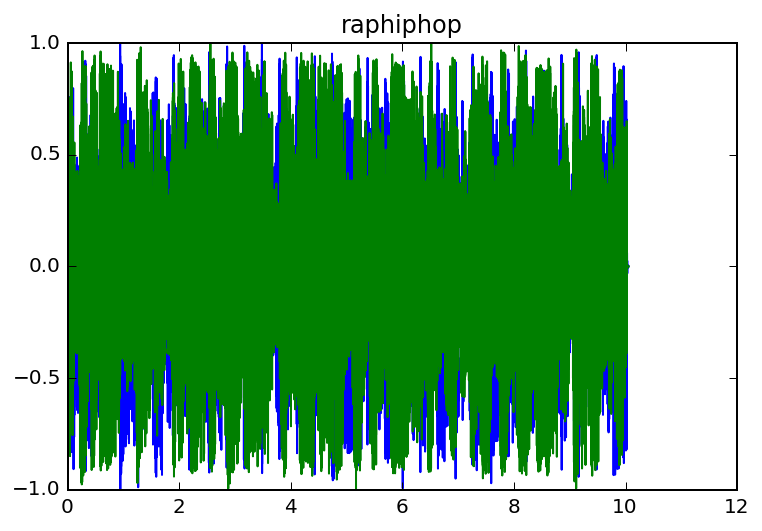

In [46]:
load_music('0013','1152', 'raphiphop' )

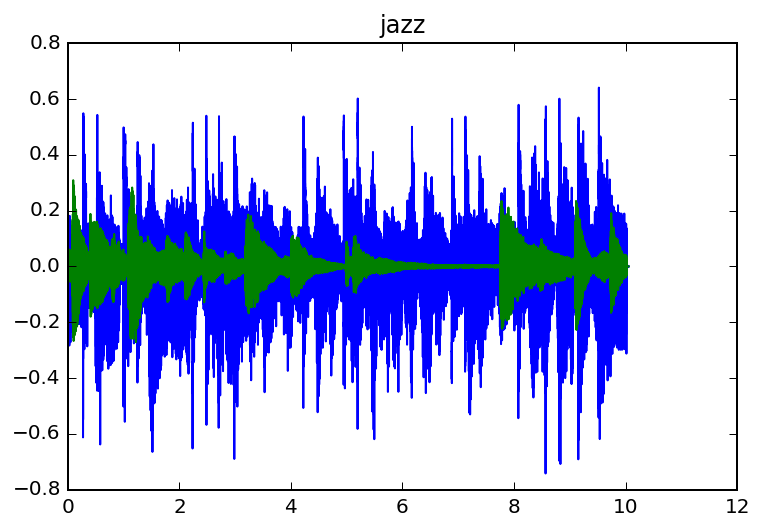

In [43]:
load_music('1157','0003', 'jazz' )

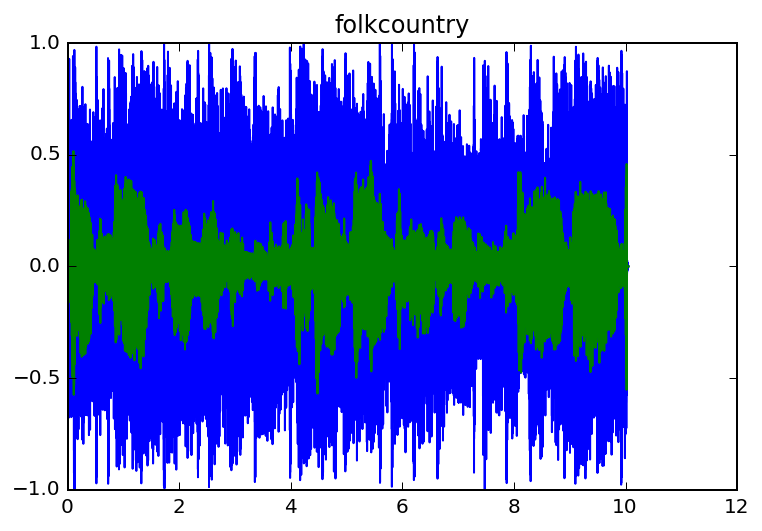

In [42]:
load_music('0005','1159', 'folkcountry' )

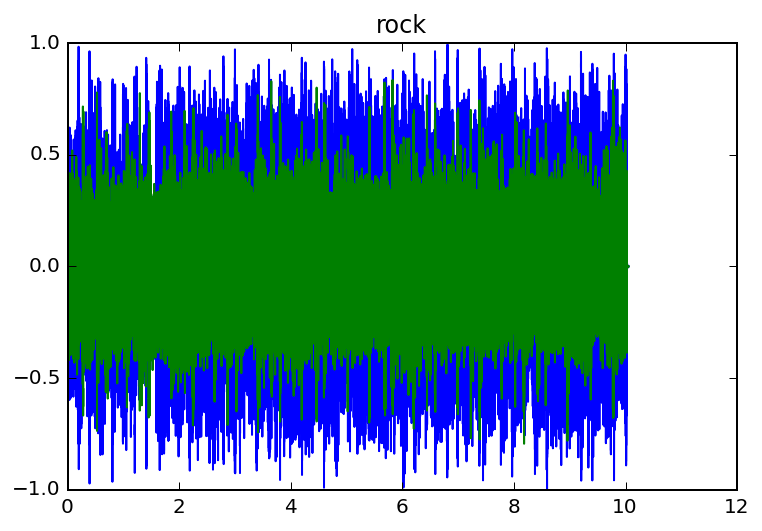

In [44]:
load_music('0008','1162', 'rock' )

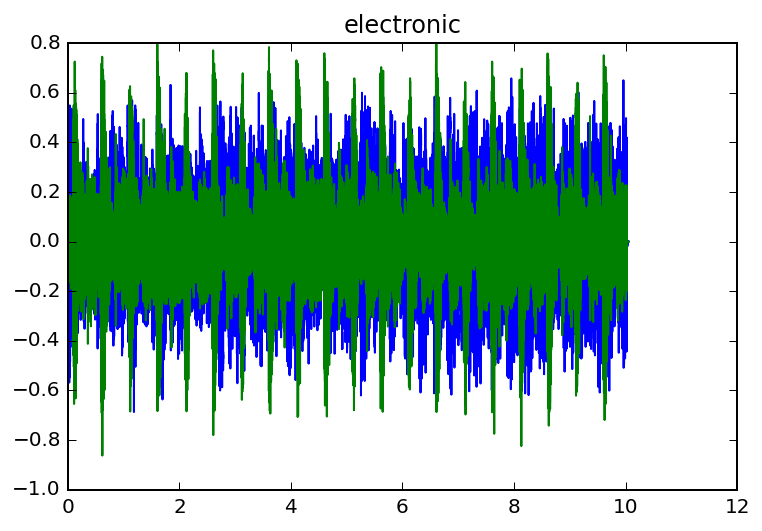

In [45]:
load_music('0010','1144', 'electronic' )

In [39]:
IPython.display.Audio(data=mono1, rate=fs1)

In [31]:
IPython.display.Audio(data=mono2, rate=fs2)

In [48]:
len(mono1)

443520

In [14]:
  df_labels = pd.read_csv('music_train_labels.csv')

In [15]:
df_labels

,filename,genre
0,train_0001.mp3,folkcountry
1,train_0002.mp3,jazz
2,train_0003.mp3,jazz
3,train_0004.mp3,jazz
4,train_0005.mp3,folkcountry
5,train_0006.mp3,jazz
6,train_0007.mp3,folkcountry
7,train_0008.mp3,rock
8,train_0009.mp3,raphiphop
9,train_0010.mp3,electronic


In [16]:
!tar -xvzf music_feature_extraction_test.tar.gz

data/feature_extraction_test/fe_test_0001.mp3
data/feature_extraction_test/fe_test_0002.mp3
data/feature_extraction_test/fe_test_0003.mp3
data/feature_extraction_test/fe_test_0004.mp3
data/feature_extraction_test/fe_test_0005.mp3
data/feature_extraction_test/fe_test_0006.mp3
data/feature_extraction_test/fe_test_0007.mp3
data/feature_extraction_test/fe_test_0008.mp3
data/feature_extraction_test/fe_test_0009.mp3
data/feature_extraction_test/fe_test_0010.mp3
data/feature_extraction_test/fe_test_0011.mp3
data/feature_extraction_test/fe_test_0012.mp3
data/feature_extraction_test/fe_test_0013.mp3
data/feature_extraction_test/fe_test_0014.mp3
data/feature_extraction_test/fe_test_0015.mp3
data/feature_extraction_test/fe_test_0016.mp3
data/feature_extraction_test/fe_test_0017.mp3
data/feature_extraction_test/fe_test_0018.mp3
data/feature_extraction_test/fe_test_0019.mp3
data/feature_extraction_test/fe_test_0020.mp3
data/feature_extraction_test/fe_test_0021.mp3
data/feature_extraction_test/fe_te

# All Features Model

In [231]:
df_anon = pd.read_csv('df_train_anon.csv',  header=None)

In [232]:
y = df_anon[549].values

In [233]:
df_anon.drop(df_anon.columns[[549]], axis=1, inplace=True)

In [234]:
X = np.array(df_anon)

In [235]:
X.shape

(1167, 549)

In [236]:
X

array([[  8.93098508e-03,   8.91137575e-05,   6.48344414e+00, ...,
          1.74138165e-01,   1.73343340e-01,   9.93840144e+01],
       [  9.04362204e-03,   1.40527913e-04,   7.25375861e+00, ...,
          5.78047997e-01,   5.78410555e-01,   1.23046875e+02],
       [  9.09430868e-03,   8.21521598e-05,   7.84542382e+00, ...,
          3.52339382e-01,   3.50118150e-01,   1.09956782e+02],
       ..., 
       [  1.61924650e-01,   2.38045192e-03,   5.15405008e-01, ...,
          4.98330765e-01,   5.01275327e-01,   1.23046875e+02],
       [  1.73311121e-01,   1.16584711e-02,   9.86115939e-01, ...,
          4.42530078e-01,   4.72949745e-01,   1.20185320e+02],
       [  1.76325287e-01,   2.42321486e-03,   4.65757137e-01, ...,
          3.02905716e-01,   3.02259539e-01,   1.01332721e+02]])

In [237]:
y.shape

(1167,)

In [238]:
y

array(['jazz', 'jazz', 'electronic', ..., 'rock', 'raphiphop', 'jazz'], dtype=object)

In [75]:
Xt = DimRedTransform(100).fit(X)

In [51]:
Xt.mean()

-8.189823515873665e-18

In [53]:
yt = labelEncodeTransformer().fit(y).transform(y)

In [54]:
yt

array([2, 2, 0, ..., 4, 3, 2])

In [111]:
from sklearn import cross_validation, ensemble
clfs = [ linear_model.LogisticRegression(), 
        tree.DecisionTreeClassifier(), 
        tree.ExtraTreeClassifier(), 
        ensemble.ExtraTreesClassifier(),
        ensemble.RandomForestClassifier(), ensemble.GradientBoostingClassifier()
]

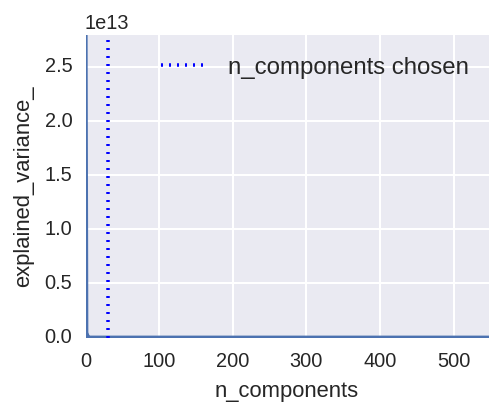

In [89]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

randomf = ensemble.RandomForestClassifier()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('randomf', randomf)])

##digits = datasets.load_digits()
X_digits = X
y_digits = yt

###############################################################################
# Plot the PCA spectrum
pca.fit(X_digits)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

###############################################################################
# Prediction

n_components = range(10,100,10)
max_depth = range(3,30, 3)

#Parameters of pipelines can be set using ‘__’ separated parameter names:

estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              randomf__max_depth=max_depth))
estimator.fit(X_digits, y_digits)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

In [90]:
estimator.best_estimator_.named_steps['pca'].n_components

30

In [112]:
# Let's try to evaluate the model on different sets of features and compare their performance

from sklearn import cross_validation
from scipy import stats

cv = cross_validation.ShuffleSplit(len(y), n_iter=20, test_size=0.2, random_state=42)
def compute_error(clf, X, y):
    return cross_validation.cross_val_score(clf, X, y, cv=cv, scoring='accuracy').mean()



In [113]:
print [compute_error(clf,Xt,yt) for clf in clfs]

[0.39380341880341885, 0.42158119658119658, 0.33055555555555549, 0.46004273504273507, 0.49294871794871797, 0.61495726495726488]


In [114]:
Xt.shape

(1167, 100)

In [119]:
from tqdm import tqdm
    

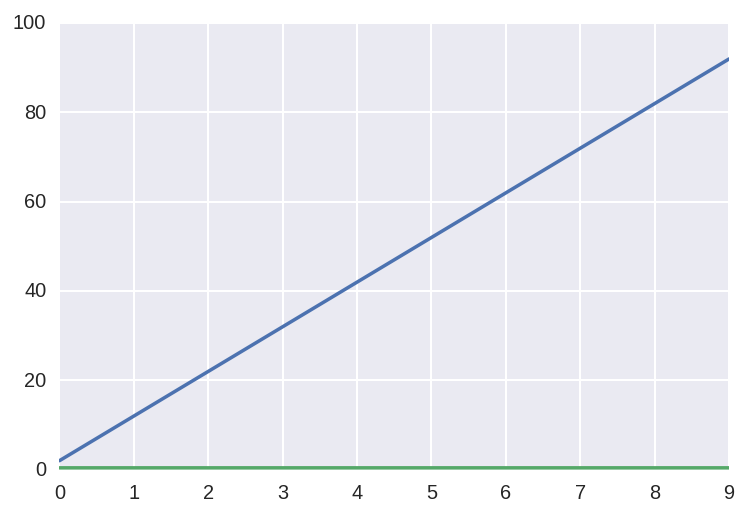

In [121]:
log_reg = []
dec_tree = []
extra_tree = []
random_forest = []
gradient_boost = []

for i in tqdm(range(2,100,10)):
    Xt = DimRedTransform(i).fit(X)
    accuracies = [compute_error(clf,Xt,yt) for clf in clfs]
    log_reg.append((i,accuracies[0]))
    dec_tree.append((i,accuracies[1]))
    extra_tree.append((i,accuracies[2]))
    random_forest.append((i,accuracies[3]))
    ##gradient_boost.append((i,accuracies[4]))
    
    
    
    
plt.plot(log_reg)
        

In [133]:
gradient_boost = []

for i in tqdm(range(2,125,25)):
    Xt = DimRedTransform(i).fit(X)
    acc = compute_error(clfs[5],Xt,yt)
    gradient_boost.append((i,acc))

In [134]:
gradient_boost

[(2, 0.4185897435897436),
 (27, 0.60982905982905977),
 (52, 0.62628205128205117),
 (77, 0.61965811965811957),
 (102, 0.62158119658119648)]

In [122]:
def plot_ncomponents():
    plt.plot(log_reg)
    plt.plot(dec_tree)
    plt.plot(extra_tree)
    plt.plot(random_forest)

In [126]:
random_forest

[(2, 0.36324786324786323),
 (12, 0.50662393162393171),
 (22, 0.50320512820512819),
 (32, 0.51196581196581192),
 (42, 0.51047008547008543),
 (52, 0.49294871794871797),
 (62, 0.47884615384615381),
 (72, 0.48354700854700849),
 (82, 0.47777777777777775),
 (92, 0.45790598290598294)]

In [261]:
class RFEstimator():
    def __init__(self):##, n_components):
        from sklearn import grid_search
        from sklearn import linear_model
        ##est = linear_model.SGDClassifier()     
        ##from sklearn import tree 
        ##est =  tree.DecisionTreeClassifier()
        ###est = ensemble.GradientBoostingClassifier()
        
        ##from sklearn import cross_validation, ensemble
        params = {'n_estimators': 500, 
                  'min_samples_split': 2,
                  'min_samples_leaf': 1,
                  'learning_rate': 0.1, 
                  'loss': 'deviance',
                  'max_depth':3,
                  'n_estimators': 100,
                  'max_features': None,
                  'subsample': 1.0             
                 }
        est = ensemble.GradientBoostingClassifier(**params)
        ##self.gs = est
        self.gs = est
        ##self.trans = DimRedTransform(n_components)
        self.encode = labelEncodeTransformer()
        pass
    
    def fit(self, X, y):
        ##X = self.trans.fit(X)
        self.encode.fit(y)
        y = self.encode.transform(y)
        self.model = self.gs.fit(X,y)
        ##print self.gs.best_params_
        return self
    
    def predict(self, x):
        ##x = self.trans.transform(x)
        y = self.model.predict(x)
        y = self.encode.inverse(y)
        return y
    
    def score(self, X, y):
        X_test = self.trans.transform(X)
        return self.model.score(X_test, y)
    

In [262]:
est = RFEstimator()

In [247]:
class labelEncodeTransformer():
    def __init__(self):
        from sklearn import preprocessing
        self.le = preprocessing.LabelEncoder()
        pass
    def fit(self,y):
        y = self.le.fit(y)
        return y
    def transform(self, y):
        y = self.le.transform(y)
        return y
    def inverse(self,y):
        y = self.le.inverse_transform(y)
        return y

In [241]:
X

array([[  8.93098508e-03,   8.91137575e-05,   6.48344414e+00, ...,
          1.74138165e-01,   1.73343340e-01,   9.93840144e+01],
       [  9.04362204e-03,   1.40527913e-04,   7.25375861e+00, ...,
          5.78047997e-01,   5.78410555e-01,   1.23046875e+02],
       [  9.09430868e-03,   8.21521598e-05,   7.84542382e+00, ...,
          3.52339382e-01,   3.50118150e-01,   1.09956782e+02],
       ..., 
       [  1.61924650e-01,   2.38045192e-03,   5.15405008e-01, ...,
          4.98330765e-01,   5.01275327e-01,   1.23046875e+02],
       [  1.73311121e-01,   1.16584711e-02,   9.86115939e-01, ...,
          4.42530078e-01,   4.72949745e-01,   1.20185320e+02],
       [  1.76325287e-01,   2.42321486e-03,   4.65757137e-01, ...,
          3.02905716e-01,   3.02259539e-01,   1.01332721e+02]])

In [263]:
model = est.fit(X, y)

In [ ]:
class GBEstimator():
    def __init__(self, n_components,n_estimators):
        from sklearn import grid_search
        from sklearn import linear_model
        ##est = linear_model.SGDClassifier()     
        ##from sklearn import tree 
        ##est =  tree.DecisionTreeClassifier()
        est = ensemble.RandomForestClassifier(n_estimators=n_estimators)
        
        ##from sklearn import cross_validation, ensemble
        ##params = {'n_estimators': 500, 'min_samples_split': 1,
         ## 'learning_rate': 0.02, 'loss': 'ls', "max_depth":3}
        ##est = ensemble.GradientBoostingRegressor(**params)
        ##self.gs = est
        self.gs = grid_search.GridSearchCV(
    est,
    {
     "max_depth": range(5,50,5)  
    }, ## 
    cv = 10,  # 5-fold cross validation
    n_jobs=2,  # run each hyperparameter in one of two parallel jobs
    scoring='accuracy'
)
        self.trans = DimRedTransform(n_components)
        self.encode = labelEncodeTransformer()
        pass
    
    def fit(self, X, y):
        X = self.trans.fit(X)
        self.encode.fit(y)
        y = self.encode.transform(y)
        self.model = self.gs.fit(X,y)
        print self.gs.best_params_
        return self
    
    def predict(self, x):
        x = self.trans.transform(x)
        y = self.model.predict(x)
        y = self.encode.inverse(y)
        return y
    
    def score(self, X, y):
        X_test = self.trans.transform(X)
        return self.model.score(X_test, y)
    

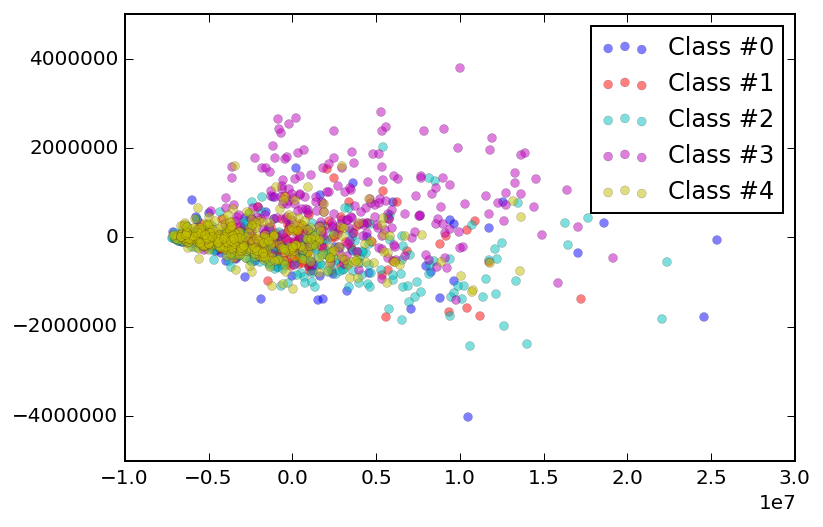

In [237]:
# Instanciate a PCA object for the sake of easy visualisation
pca = RandomizedPCA(n_components = 2)

# Fit and transform x to visualise inside a 2D feature space
x_vis = pca.fit_transform(X)

# Plot the original data
# Plot the two classes
palette = sns.color_palette()
plt.scatter(x_vis[y==0, 0], x_vis[y==0, 1], label="Class #0", alpha=0.5, 
            edgecolor='#262626', facecolor=palette[0], linewidth=0.15)
plt.scatter(x_vis[y==1, 0], x_vis[y==1, 1], label="Class #1", alpha=0.5, 
            edgecolor='#262344', facecolor=palette[2], linewidth=0.15)
plt.scatter(x_vis[y==2, 0], x_vis[y==2, 1], label="Class #2", alpha=0.5, 
            edgecolor='#262500', facecolor=palette[3], linewidth=0.15)
plt.scatter(x_vis[y==3, 0], x_vis[y==3, 1], label="Class #3", alpha=0.5, 
            edgecolor='#100626', facecolor=palette[4], linewidth=0.15)
plt.scatter(x_vis[y==4, 0], x_vis[y==4, 1], label="Class #4", alpha=0.5, 
            edgecolor='#400626', facecolor=palette[5], linewidth=0.15)

plt.legend()
plt.show()

In [301]:
x_vis.shape

(1167, 2)

In [302]:
record= X[22]

In [303]:
rec_vis = pca.transform(record)

In [304]:
rec_vis

array([[-6215549.1721006,   -94049.9855681]])

In [195]:
class DimRedTransform():
    def __init__(self, n_components):
        from sklearn.preprocessing import StandardScaler
        from sklearn.decomposition import PCA
        from sklearn.decomposition import RandomizedPCA  
        ##self.trans = RandomizedPCA(n_components = n_components)
        self.norm =  StandardScaler()
        self.trans = PCA(n_components = n_components)
        pass
    def fit(self,X):
        X = self.norm.fit_transform(X)
        X = self.trans.fit_transform(X)
        return X
    def transform(self, x):
        x = self.norm.transform(x)
        x = self.trans.transform(x)
        return x
        
       

In [204]:
import sklearn as sk
class ShellEstimator(sk.base.BaseEstimator, sk.base.RegressorMixin):
    """
    A shell estimator that combines a transformer and regressor into a single object.
    """
    def __init__(self, transformer, model):
        self.transformer = transformer
        self.model = model
        pass

    def fit(self, X, y):
        X_trans = self.transformer.fit(X, y).transform(X)
        self.model.fit(X_trans, y)
        return self
    
    def score(self, X, y):
        X_test = self.transformer.transform(X)
        return self.model.score(X_test, y)

    def predict(self, X):
        X_test = self.transformer.transform(X)
        return self.model.predict(X_test)

In [ ]:
model = ShellEstimator(PCA(n_components = ))

In [98]:
class DTEstimator():
    def __init__(self, n_components):
        from sklearn import grid_search
        from sklearn import linear_model
        ##est = linear_model.SGDClassifier()     
        ##from sklearn import tree 
        ##est =  tree.DecisionTreeClassifier()
        est = linear_model.LogisticRegression()
        ##from sklearn import cross_validation, ensemble
        ##params = {'n_estimators': 500, 'min_samples_split': 1,
         ## 'learning_rate': 0.02, 'loss': 'ls', "max_depth":3}
        ##est = ensemble.GradientBoostingRegressor(**params)
        ##self.gs = est
        self.gs = grid_search.GridSearchCV(
    est,
    {"C": np.logspace(-2,4,22)}, ## 
    cv = 10,  # 5-fold cross validation
    n_jobs=2,  # run each hyperparameter in one of two parallel jobs
    scoring='accuracy'
)
        self.trans = DimRedTransform(n_components)
        self.encode = labelEncodeTransformer()
        pass
    
    def fit(self, X, y):
        X = self.trans.fit(X)
        self.encode.fit(y)
        y = self.encode.transform(y)
        self.model = self.gs.fit(X,y)
        print self.gs.best_params_
        return self
    
    def predict(self, x):
        x = self.trans.transform(x)
        y = self.model.predict(x)
        y = self.encode.inverse(y)
        return y
    
    def score(self, X, y):
        X_test = self.trans.transform(X)
        return self.model.score(X_test, y)
    


In [99]:
est = DTEstimator(80)

In [103]:
model = est.fit(X,y)

{'C': 10000.0}


In [24]:
 np.logspace(-2,4,22)

array([  1.00000000e-02,   1.93069773e-02,   3.72759372e-02,
         7.19685673e-02,   1.38949549e-01,   2.68269580e-01,
         5.17947468e-01,   1.00000000e+00,   1.93069773e+00,
         3.72759372e+00,   7.19685673e+00,   1.38949549e+01,
         2.68269580e+01,   5.17947468e+01,   1.00000000e+02,
         1.93069773e+02,   3.72759372e+02,   7.19685673e+02,
         1.38949549e+03,   2.68269580e+03,   5.17947468e+03,
         1.00000000e+04])

In [229]:
trans = DimRedTransform(20)

In [230]:
X = trans.fit(X)

In [231]:
X.shape

(1167, 20)

In [216]:
y

array([2, 2, 0, ..., 4, 3, 2])

In [35]:
tree_reg = tree.DecisionTreeClassifier()
pd.DataFrame([
    ("Mean Model", y.var()),
    ("Decision Tree", compute_error(tree_reg, X, y))
], columns=["Model", "Acccuracy"]).plot(x="Model", y="Accuracy", kind="Bar")

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [36]:
lr_reg = linear_model.LogisticRegression()
pd.DataFrame([
    ("Mean Model", 0.25,
    ("Logistic Regression", compute_error(lr_reg, X, y))
], columns=["Model", "MSE"]).plot(x="Model", y="MSE", kind="Bar")

SyntaxError: invalid syntax (<ipython-input-36-e5471313e275>, line 5)

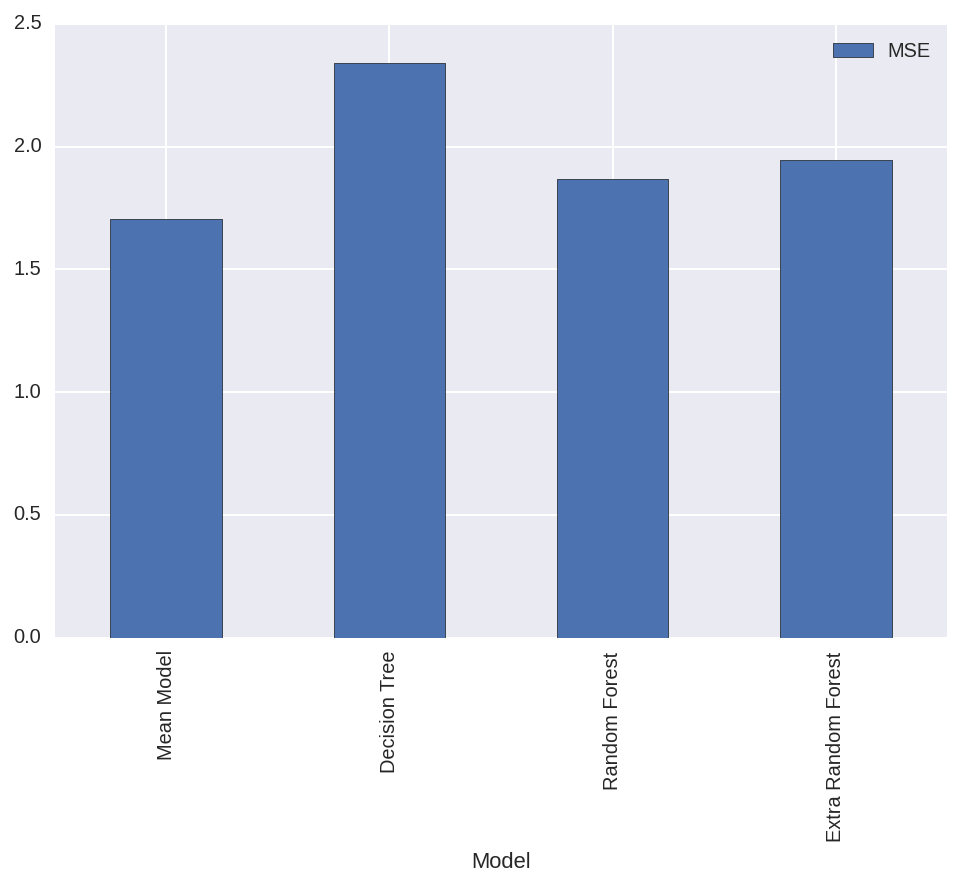

In [226]:
# Train random forests with default parameters.  Can you do better?
from sklearn import cross_validation, ensemble
import pandas as pd

tree_reg = tree.DecisionTreeClassifier()
extra_reg = ensemble.ExtraTreesClassifier()
forest_reg = ensemble.RandomForestClassifier()

model_performance = pd.DataFrame([
    ("Mean Model", y.var()),
    ("Decision Tree", compute_error(tree_reg, X, y)),
    ("Random Forest", compute_error(forest_reg, X, y)),
    ("Extra Random Forest", compute_error(extra_reg, X, y)),
], columns=["Model", "MSE"])
model_performance.plot(x="Model", y="MSE", kind="Bar")

In [106]:
# GradientBoostingRegressor
# Fit regression model
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.02 ##, 'loss': 'ls'
         }

gradient_reg = ensemble.GradientBoostingClassifier(**params)



In [208]:
pd.DataFrame([
    tree_reg.fit(X, y).feature_importances_,
    forest_reg.fit(X, y).feature_importances_,
    extra_reg.fit(X, y).feature_importances_,
    gradient_reg.fit(X, y).feature_importances_
], columns=columns, index=["Tree", "Forest", "Extra Random", "Gradient"]).T.plot(kind="bar").legend(loc="upper left")

NameError: name 'forest_reg' is not defined

In [188]:
X_train = X[:700]

In [200]:
X_train.shape

(700, 549)

In [189]:
X_test = X[700:]

In [38]:
trans = labelEncodeTransformer()

In [39]:
trans.fit(y)

LabelEncoder()

In [40]:
y = trans.transform(y)

In [41]:
y.var()

1.7058673651083165

In [193]:
y_test = trans.transform(y[700:])

In [158]:
from sklearn import pipeline

k_pipe = pipeline.Pipeline([
  ('features', DimRedTransform(50)),
  ('estimator', linear_model.LogisticRegression())
  ])
k_pipe.fit(X_train, y_train)
print k_pipe.score(X_test, y_test)

NameError: name 'X_train' is not defined

In [159]:
from sklearn import cross_validation
from scipy import stats

cv = cross_validation.ShuffleSplit(len(y), n_iter=20, test_size=0.2, random_state=42)
def compute_error(clf, X, y):
    return -cross_validation.cross_val_score(clf, X, y, cv=cv, scoring='accuracy').mean()

def abs_corr(x, y):
    return np.abs(stats.pearsonr(x, y)[0])

In [163]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin 
from sklearn import neighbors
from sklearn import ensemble

# To create your own estimator, simply create a subclass of BaseEstimator, RegressorMixin
# and implement the __init__, fit, and predict functions
# To learn more about rolling your own estimator, checkout
# http://scikit-learn.org/stable/developers/#rolling-your-own-estimator

class EnsembleRegressor(BaseEstimator, RegressorMixin ):
    """Joins a linear, random forest, and nearest neighbors model."""
    def __init__(self, n_components, C, n_neighbors,min_samples_leaf):
        from sklearn.base import BaseEstimator, RegressorMixin 
        from sklearn import neighbors
        from sklearn import ensemble
        from sklearn import linear_model
        self.trans = DimRedTransform(n_components=n_components)
        self.encode = labelEncodeTransformer()
        self.C = C
        self.n_neighbors = n_neighbors
        self.min_samples_leaf = min_samples_leaf
        pass
    
    def fit(self, X, y):
        import pandas as pd
        X = self.trans.fit(X)
        self.encode.fit(y)
        y = self.encode.transform(y)        
        
        self.logistic_regression = linear_model.LogisticRegression(C=self.C).fit(X, y)
        y_err = y - self.logistic_regression.predict(X)

        self.nearest_neighbors = neighbors.KNeighborsClassifier(n_neighbors=self.n_neighbors).fit(X, y_err)
        self.random_forest = ensemble.RandomForestClassifier(min_samples_leaf=self.min_samples_leaf).fit(X, y_err)

        X_ensemble = pd.DataFrame({
            "NEAR": self.nearest_neighbors.predict(X),
            "FOREST": self.random_forest.predict(X),
            "LINEAR": self.logistic_regression.predict(X),
        })
        self.ensemble_regression = linear_model.LogisticRegression().fit(X_ensemble, y)
        return self
    
    def predict(self, x):   
        import pandas as pd
        x_ensemble = pd.DataFrame({
            "NEAR": self.nearest_neighbors.predict(self.trans.transform(x)),
            "FOREST": self.random_forest.predict(self.trans.transform(x)),
            "LINEAR": self.logistic_regression.predict(self.trans.transform(x)),
        })
        return self.encode.inverse(self.ensemble_regression.predict(x_ensemble))


In [164]:
est = EnsembleRegressor(500, 0.0001, 5, 15)

In [ ]:
self.gs = grid_search.GridSearchCV(
    EnsembleRegressor(),
    {"C": np.logspace(-2,2,22),
     "n_components": range(10,50),
     "n_neighbors": range(1,20),
      "min_sample_leaf": range(5,40)}, ## 
    cv = 10,  # 5-fold cross validation
    n_jobs=2,  # run each hyperparameter in one of two parallel jobs
    scoring='mean_squared_error'
)

In [165]:
model = est.fit(X,y)

In [184]:
X.shape

(1167, 549)

In [257]:
record = X[22]

In [258]:
len(record)

549

In [259]:
model.predict(record)[0]

'jazz'

In [260]:
import dill
with open('model.dill', 'w') as f:
    dill.dump(model,f)

In [285]:
trans = DimRedTransform(50)

In [286]:
trans

<__main__.DimRedTransform instance at 0x7fa3e9be6f38>

In [287]:
Xt = trans.fit(X)

In [288]:
Xt.shape

(1167, 50)

In [292]:
record = np.array(record)[np.newaxis]

In [293]:
record.shape

(1, 549)

In [298]:
xt = trans.transform(record)

In [299]:
xt

In [300]:
xt.shape

AttributeError: 'NoneType' object has no attribute 'shape'